In [72]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
import numpy as np 
import datetime
import math
import rick
import geopandas as gpd
import os
import shapely
from shapely.geometry import Point
#os.environ["PROJ_LIB"]=r"C:\Users\rliu4\AppData\Local\Continuum\anaconda3\Library\share"
import importlib
import matplotlib.ticker as ticker

CONFIG = configparser.ConfigParser()
CONFIG.read('/home/rliu/bdit_vfh/config.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [73]:
mpl.rcParams['figure.dpi'] = 450

In [74]:
query = '''

WITH sum AS (
SELECT extract(month from pickup_datetime) as mon, extract(year from pickup_datetime) as yr, extract(week from pickup_datetime) as wk, pickup_neighbourhood, 
sum(count) as count  FROM ptc.trip_data_agg_neighbourhood
GROUP BY   pickup_datetime, pickup_neighbourhood

), ward1 AS  (

SELECT  avg(count) as count, pickup_neighbourhood from sum
WHERE (yr=2018 AND mon IN (9))
GROUP BY pickup_neighbourhood
ORDER BY count
), ward2 AS  (

SELECT avg(count) as count, pickup_neighbourhood from sum
WHERE (yr=2016 AND mon IN (10))
GROUP BY pickup_neighbourhood
ORDER BY count
)

SELECT pickup_neighbourhood,  geom, (b.count - a.count)/(a.count)*100 as growth FROM ward2 a 
LEFT JOIN ward1 b USING ( pickup_neighbourhood)
LEFT JOIN gis.neighbourhood ON area_s_cd::integer=pickup_neighbourhood

'''

data = gpd.GeoDataFrame.from_postgis(query, con, geom_col='geom')
data = data.to_crs({'init' :'epsg:3857'})

for index, row in data.iterrows():
    rotated = shapely.affinity.rotate(row['geom'], angle=-17, origin = Point(0, 0))
    data.at[index, 'geom'] = rotated

In [75]:
data=data[['geom', 'growth']]

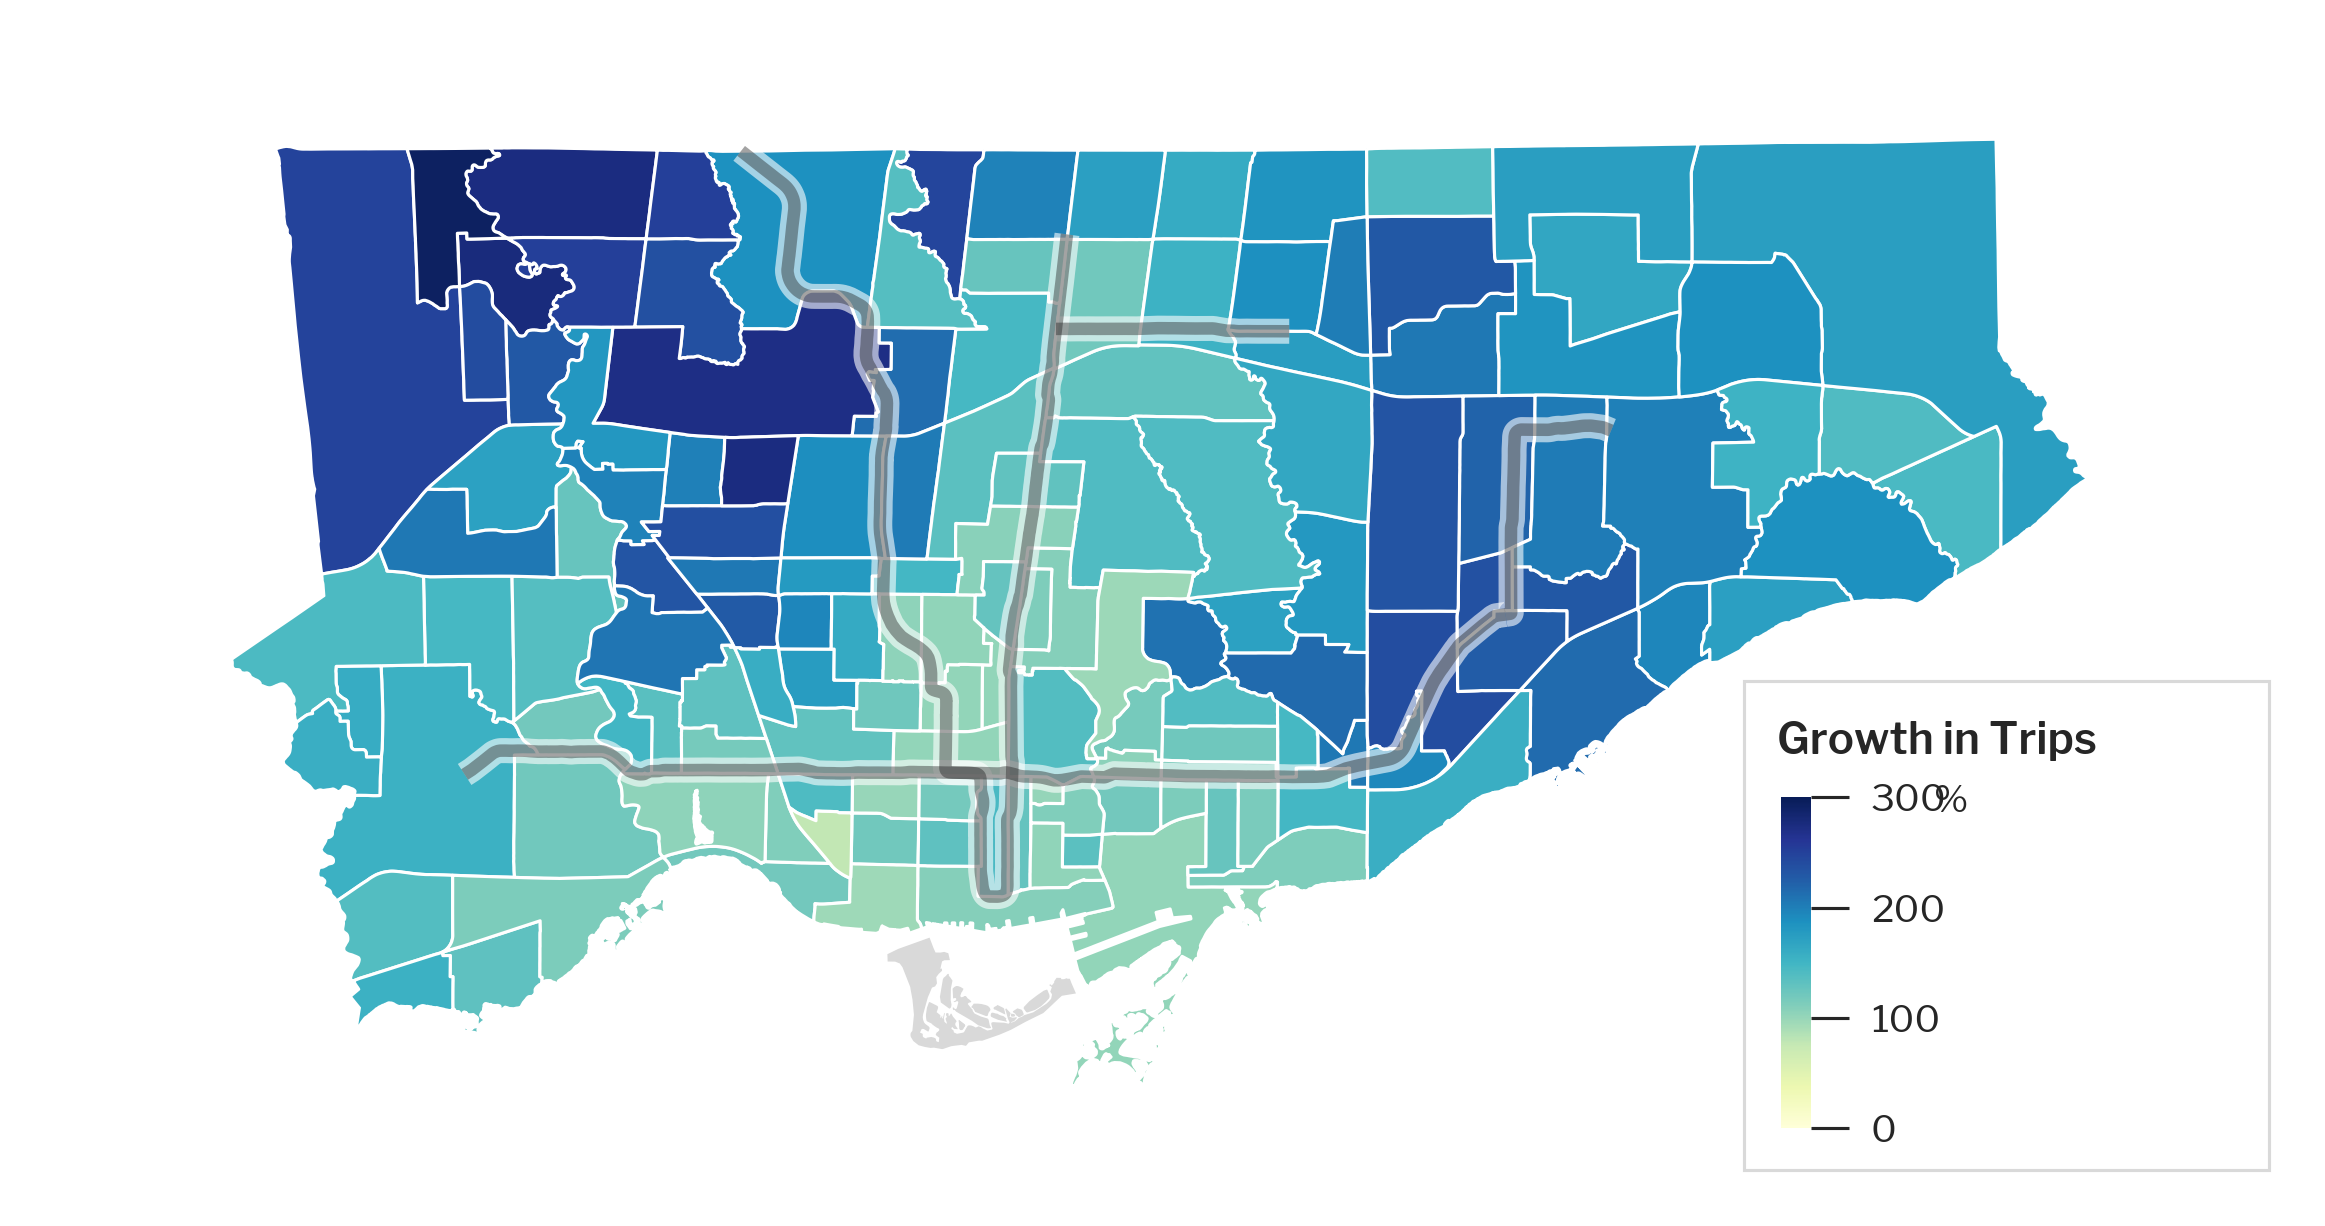

In [76]:
fig, ax = rick.charts.chloro_map(con, data, subway = True, lower = 0, upper = 300, title = 'Growth in Trips', 
                                       island = False, cmap = 'YlGnBu', unit = '%', nbins = 3)

In [77]:
query='''
WITH daily_ave AS (

SELECT * FROM ptc.daily_trips
), total AS  (
SELECT  extract(month from pickup_datetime) as mon,
extract(year from pickup_datetime) as yr,

CASE WHEN extract(year from pickup_datetime) = 2018 AND extract(month from pickup_datetime) IN (3) THEN 108321
WHEN extract(year from pickup_datetime) = 2018 AND extract(month from pickup_datetime) IN (11) THEN 161733 ELSE
avg(count)::integer END as count FROM daily_ave
GROUP BY extract(month from pickup_datetime), extract(year from pickup_datetime)
ORDER BY extract(year from pickup_datetime), extract(month from pickup_datetime)
)


SELECT 
CASE WHEN mon = 1 THEN to_char(to_timestamp (mon::text, 'MM'), 'Mon')||' '||yr::text 
WHEN mon = 9 AND yr = 2016 THEN to_char(to_timestamp (mon::text, 'MM'), 'Mon')||' '||yr::text 
ELSE to_char(to_timestamp (mon::text, 'MM'), 'Mon')
END AS period, 
count FROM total
'''
total=pandasql.read_sql(query, con)

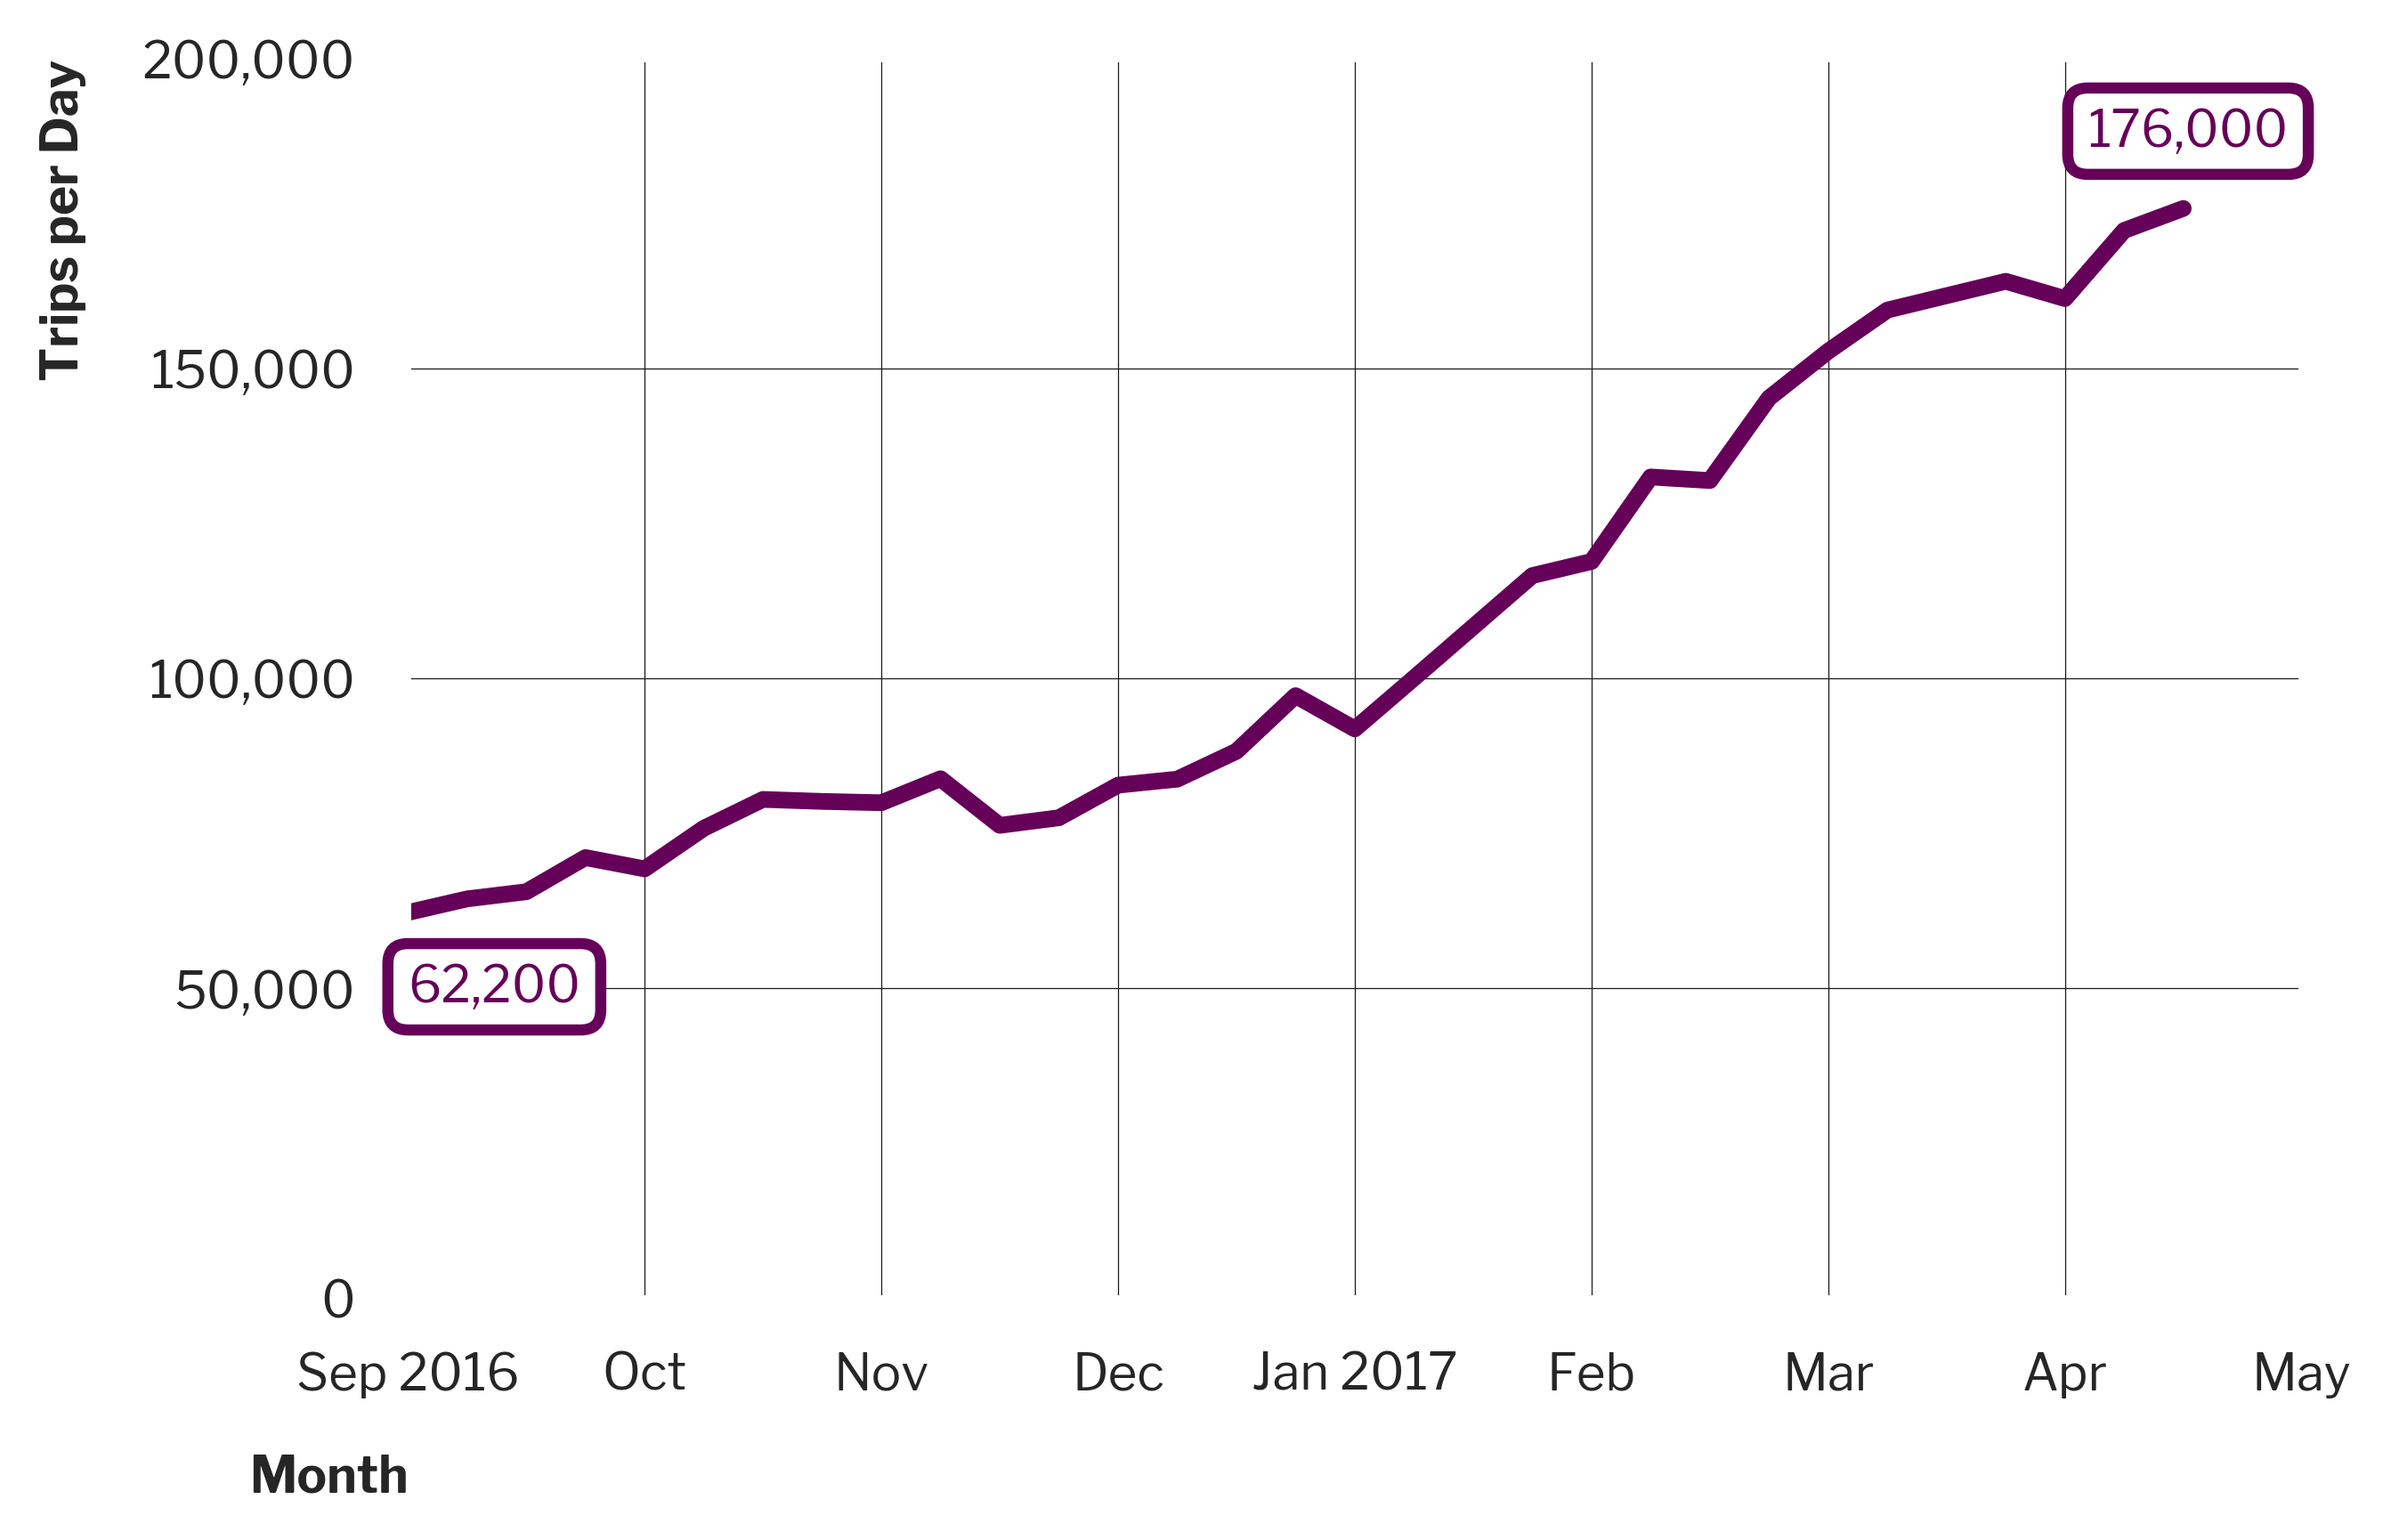

In [79]:
fig, ax =plt.subplots()

purple = '#660159'

ax.plot(total.index.values.tolist(), total['count'] ,linewidth=3, color = purple)
plt.grid()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_facecolor('xkcd:white')

plt.xlabel('Month', fontsize=9, fontweight = 'bold', horizontalalignment='right', x=0, labelpad=10, 
           fontname = 'Libre Franklin')
ax.grid(color='k', linestyle='-', linewidth=0.2)
plt.ylabel('Trips per Day', fontsize=9, fontweight = 'bold', horizontalalignment='right', y=1.0, 
           labelpad=10, fontname = 'Libre Franklin')
fig.set_size_inches(6.1, 4.1)

plt.xticks(range(0,35,4),  total['period'], fontsize=9, fontname = 'Libre Franklin')
plt.yticks(range(0,250000,50000),fontsize=9, fontname = 'Libre Franklin')

props = dict(boxstyle='round, pad=0.4',edgecolor=purple, linewidth = 2, facecolor = 'w', alpha=1)
plt.text(0.0, 0.27, '62,200', transform=ax.transAxes, wrap = True, fontsize=9, fontname = 'Libre Franklin',
        verticalalignment='top', bbox=props, color = purple)

plt.text(0.94, 0.96, '176,000', transform=ax.transAxes, wrap = True, fontsize=9, fontname = 'Libre Franklin',
         verticalalignment='top', ha = 'center', bbox=props, color = purple)

ax.set_xlim([0,32])
ax.set_ylim([0,200000])
fig.patch.set_facecolor('w')
plt.show() 

In [170]:
fig, ax = rick.charts.line_chart(total['count'], 'Trips', 'Time')

TypeError: line_chart() missing 3 required positional arguments: 'yinc', 'ylab', and 'xlab'

In [81]:
fig.text(0.94, 0.96, '176,000', transform=ax.transAxes, wrap = True, fontsize=9, fontname = 'Libre Franklin',
         verticalalignment='top', ha = 'center', bbox=props, color = purple)

Text(0.94, 0.96, '176,000')

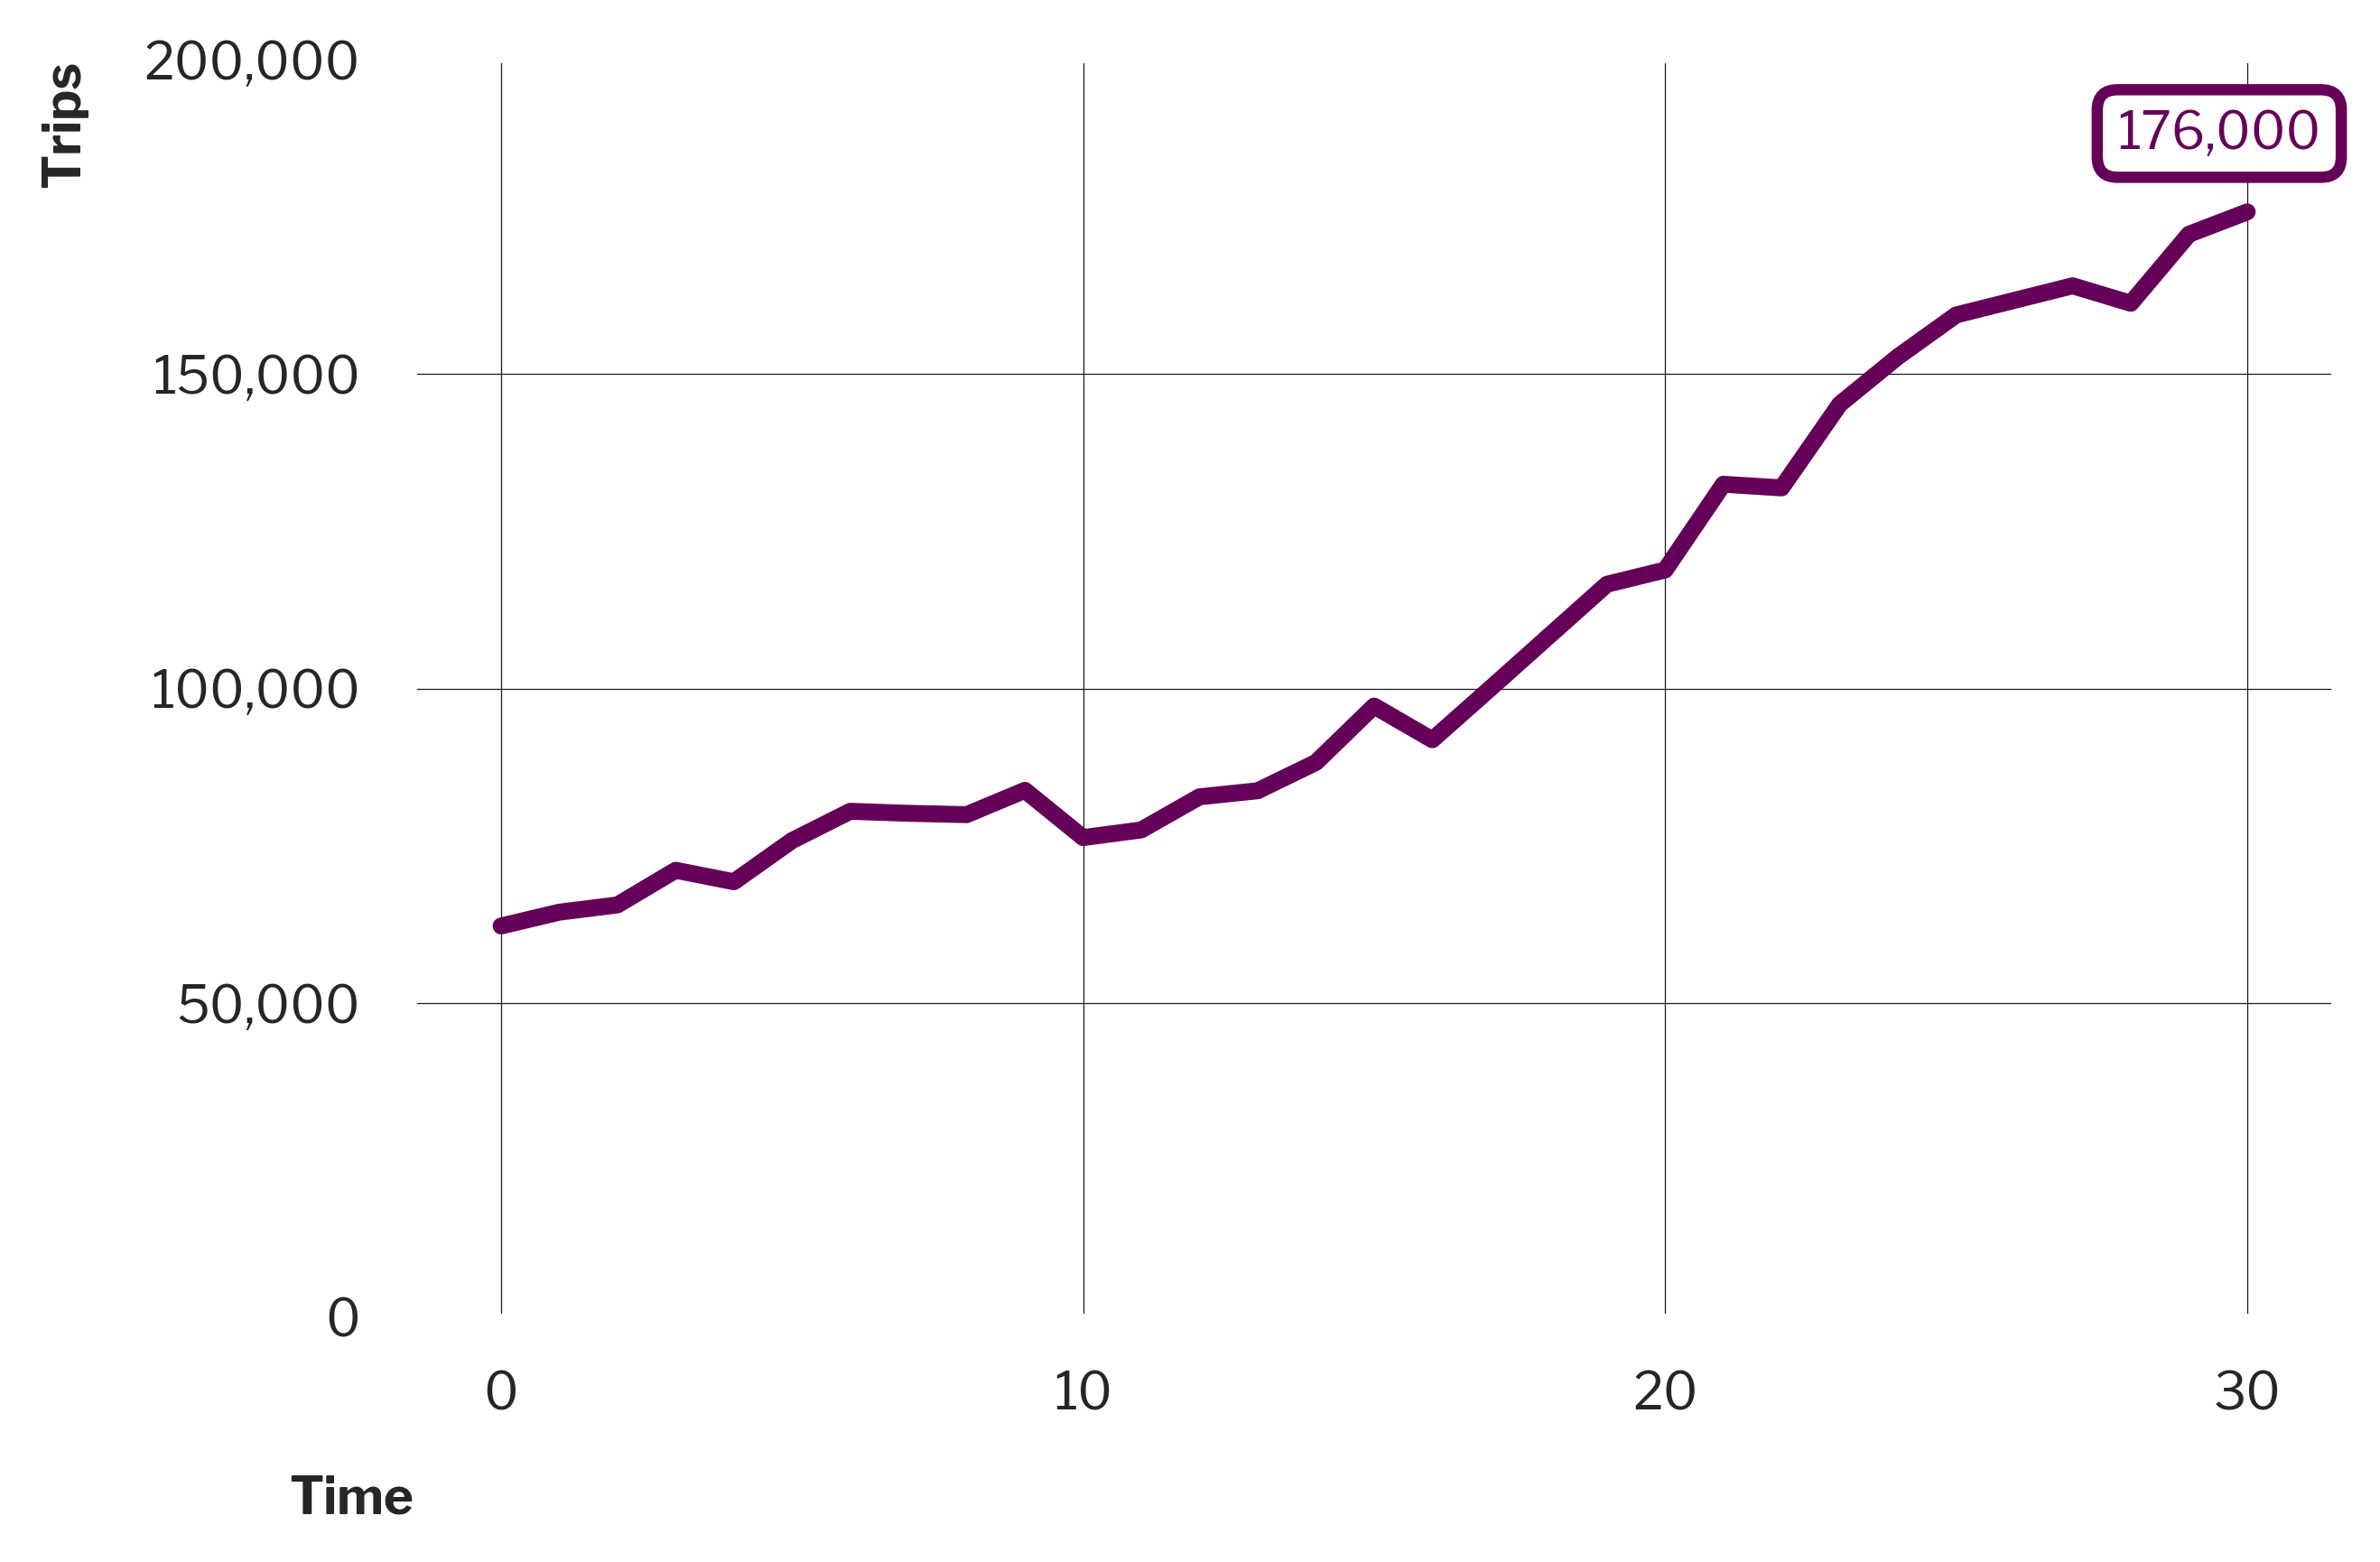

In [82]:
fig

In [83]:
query = '''

WITH sum AS (

SELECT pickup_datetime, hr, sum(count) as count, extract(month from pickup_datetime) as mon, extract(year from pickup_datetime) as yr,
extract(dow from pickup_datetime) as dow FROM ptc.trip_data_agg_ward_25


WHERE pickup_datetime > '2018-08-31'
GROUP BY pickup_datetime, hr

)
, collect AS (
SELECT  avg(count) as count, hr, dow from sum
group by hr, dow)

SELECT period_name, period_uid, count, hr, CASE WHEN dow = 0 THEN 7 ELSE dow END AS dow, 
CASE WHEN swatch IS NULL THEN '#999999' ELSE swatch END AS swatch
FROM collect
LEFT JOIN ptc.period_lookup_simple ON dow=period_dow AND hr=period_hr
LEFT JOIN ptc.periods_simple USING (period_uid)
ORDER BY dow, hr

'''
count_18 = pandasql.read_sql(query,con)

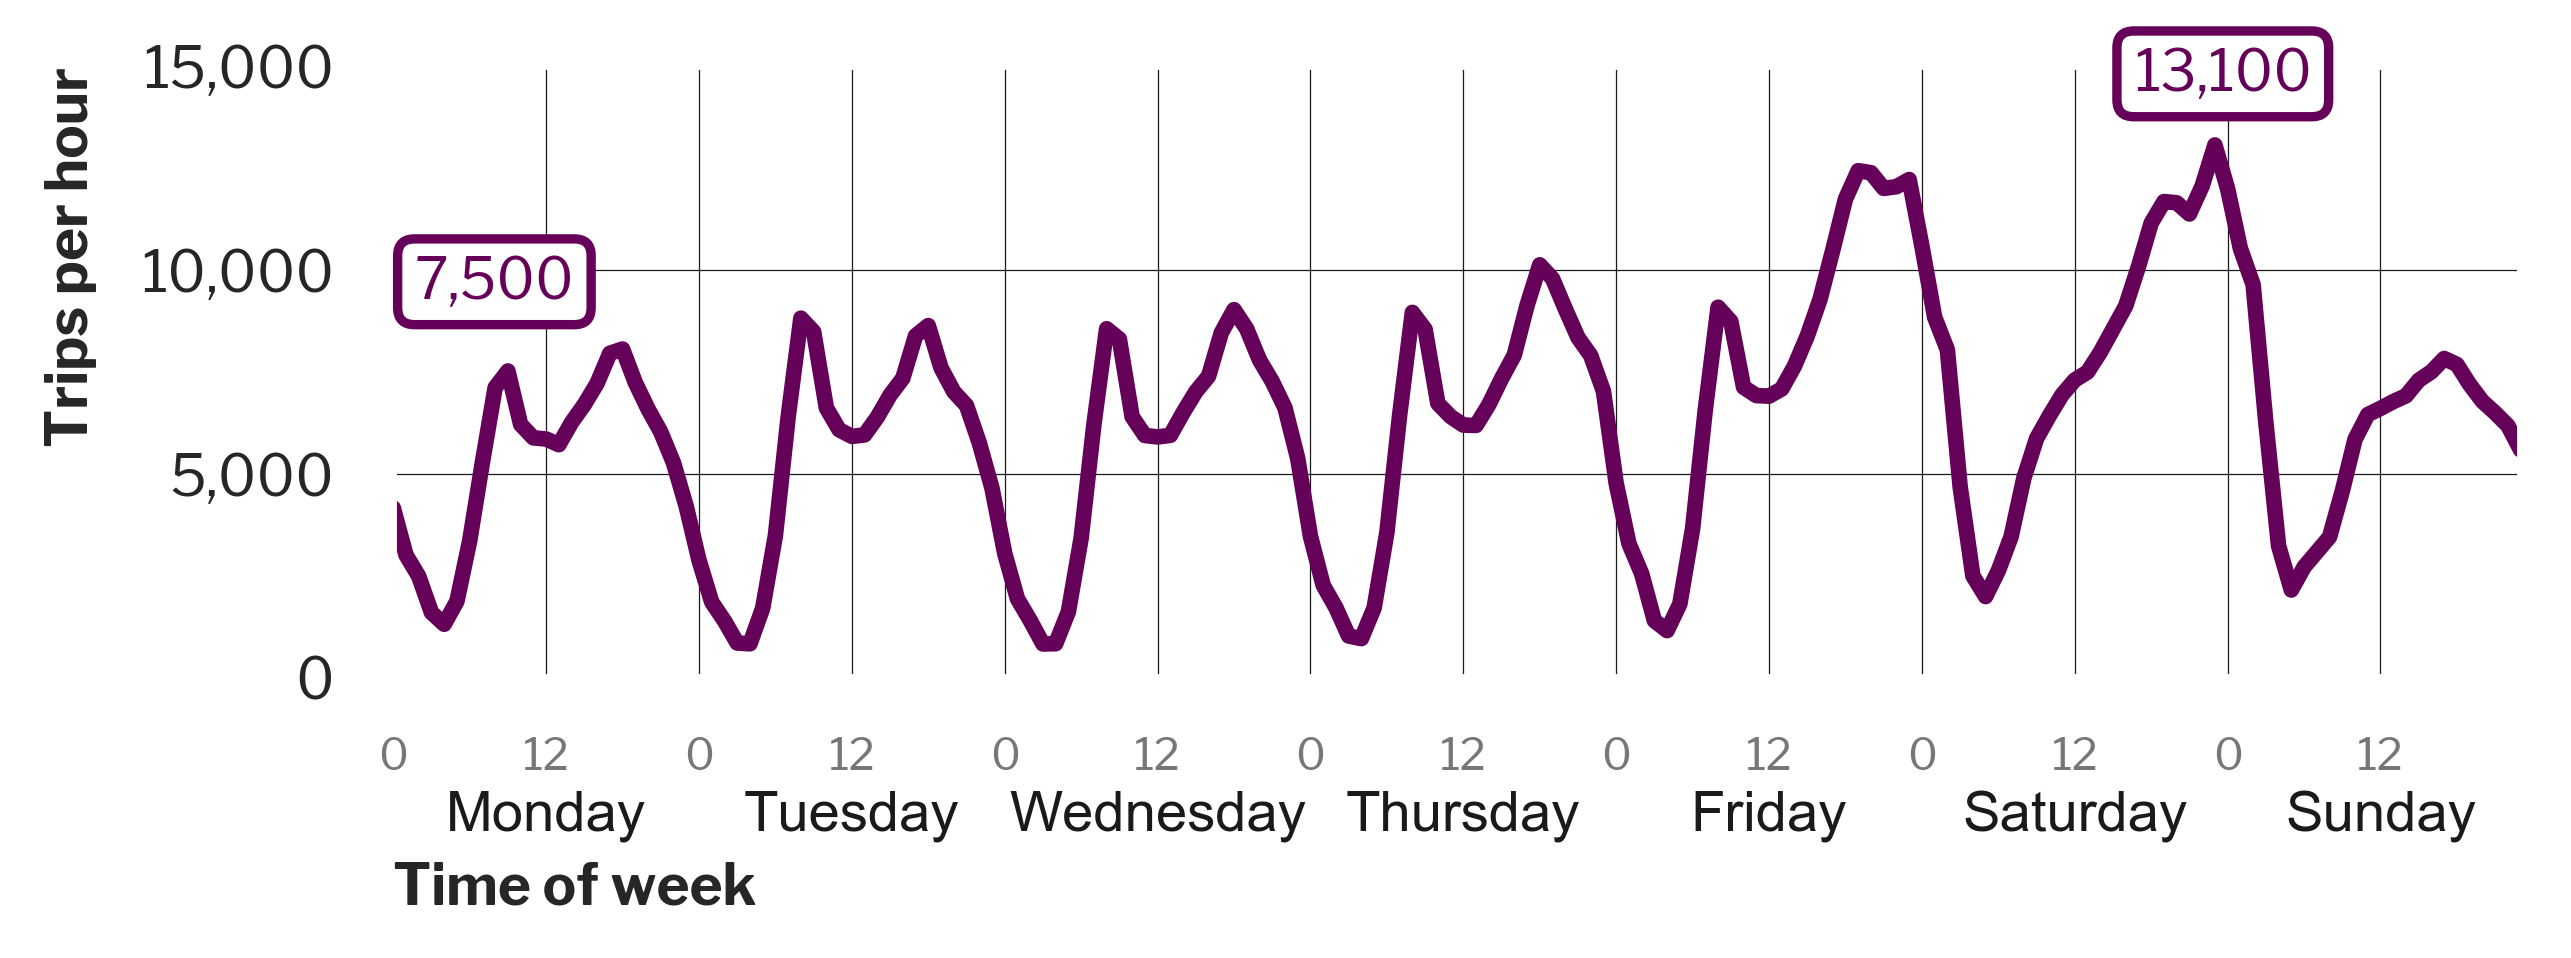

In [85]:
fig, ax =plt.subplots()
ax.plot(count_18['count'], linewidth = 2.5, color = purple)

plt.grid()
ax.set_facecolor('xkcd:white')

plt.xlabel('Time of week', fontname = 'Libre Franklin', fontsize=9, horizontalalignment='left', x=0, labelpad=3, fontweight = 'bold')
ax.set_ylim([0,15000])

ax.grid(color='k', linestyle='-', linewidth=0.2)
plt.ylabel('Trips per hour', fontname = 'Libre Franklin', fontsize=9, horizontalalignment='right', y=1, labelpad=7, fontweight = 'bold')
fig.set_size_inches(6.1, 1.8)



ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.yticks(range(0,16000,5000), fontsize =9)

ax.set_xticks(range(0,180,12))
ax.set_xticklabels(['0','12','0','12',
                                                    '0','12','0','12',
                                 '0','12','0','12','0','12'], fontname = 'Libre Franklin', fontsize = 7, color = '#777777')

ax.xaxis.set_minor_locator(ticker.FixedLocator(list(range(12,180,24))))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(['Monday','Tuesday',
                                                    'Wednesday','Thursday',
                                 'Friday','Saturday','Sunday']))
plt.yticks( fontname = 'Libre Franklin', fontsize=9)
ax.tick_params(axis='x', which='minor', colors = 'k', labelsize=9, pad =14)

props = dict(boxstyle='round, pad=0.3',edgecolor=purple, linewidth = 1.5, facecolor = 'w', alpha=1)
plt.text(0.01, 0.69, '7,500', transform=ax.transAxes, wrap = True, fontsize=9, fontname = 'Libre Franklin',
        verticalalignment='top', bbox=props, color = purple)

plt.text(0.86, 1.03, '13,100', transform=ax.transAxes, wrap = True, fontsize=9, fontname = 'Libre Franklin',
        verticalalignment='top', ha = 'center', bbox=props, color = purple)

ax.set_xlim([0,167])
plt.show()

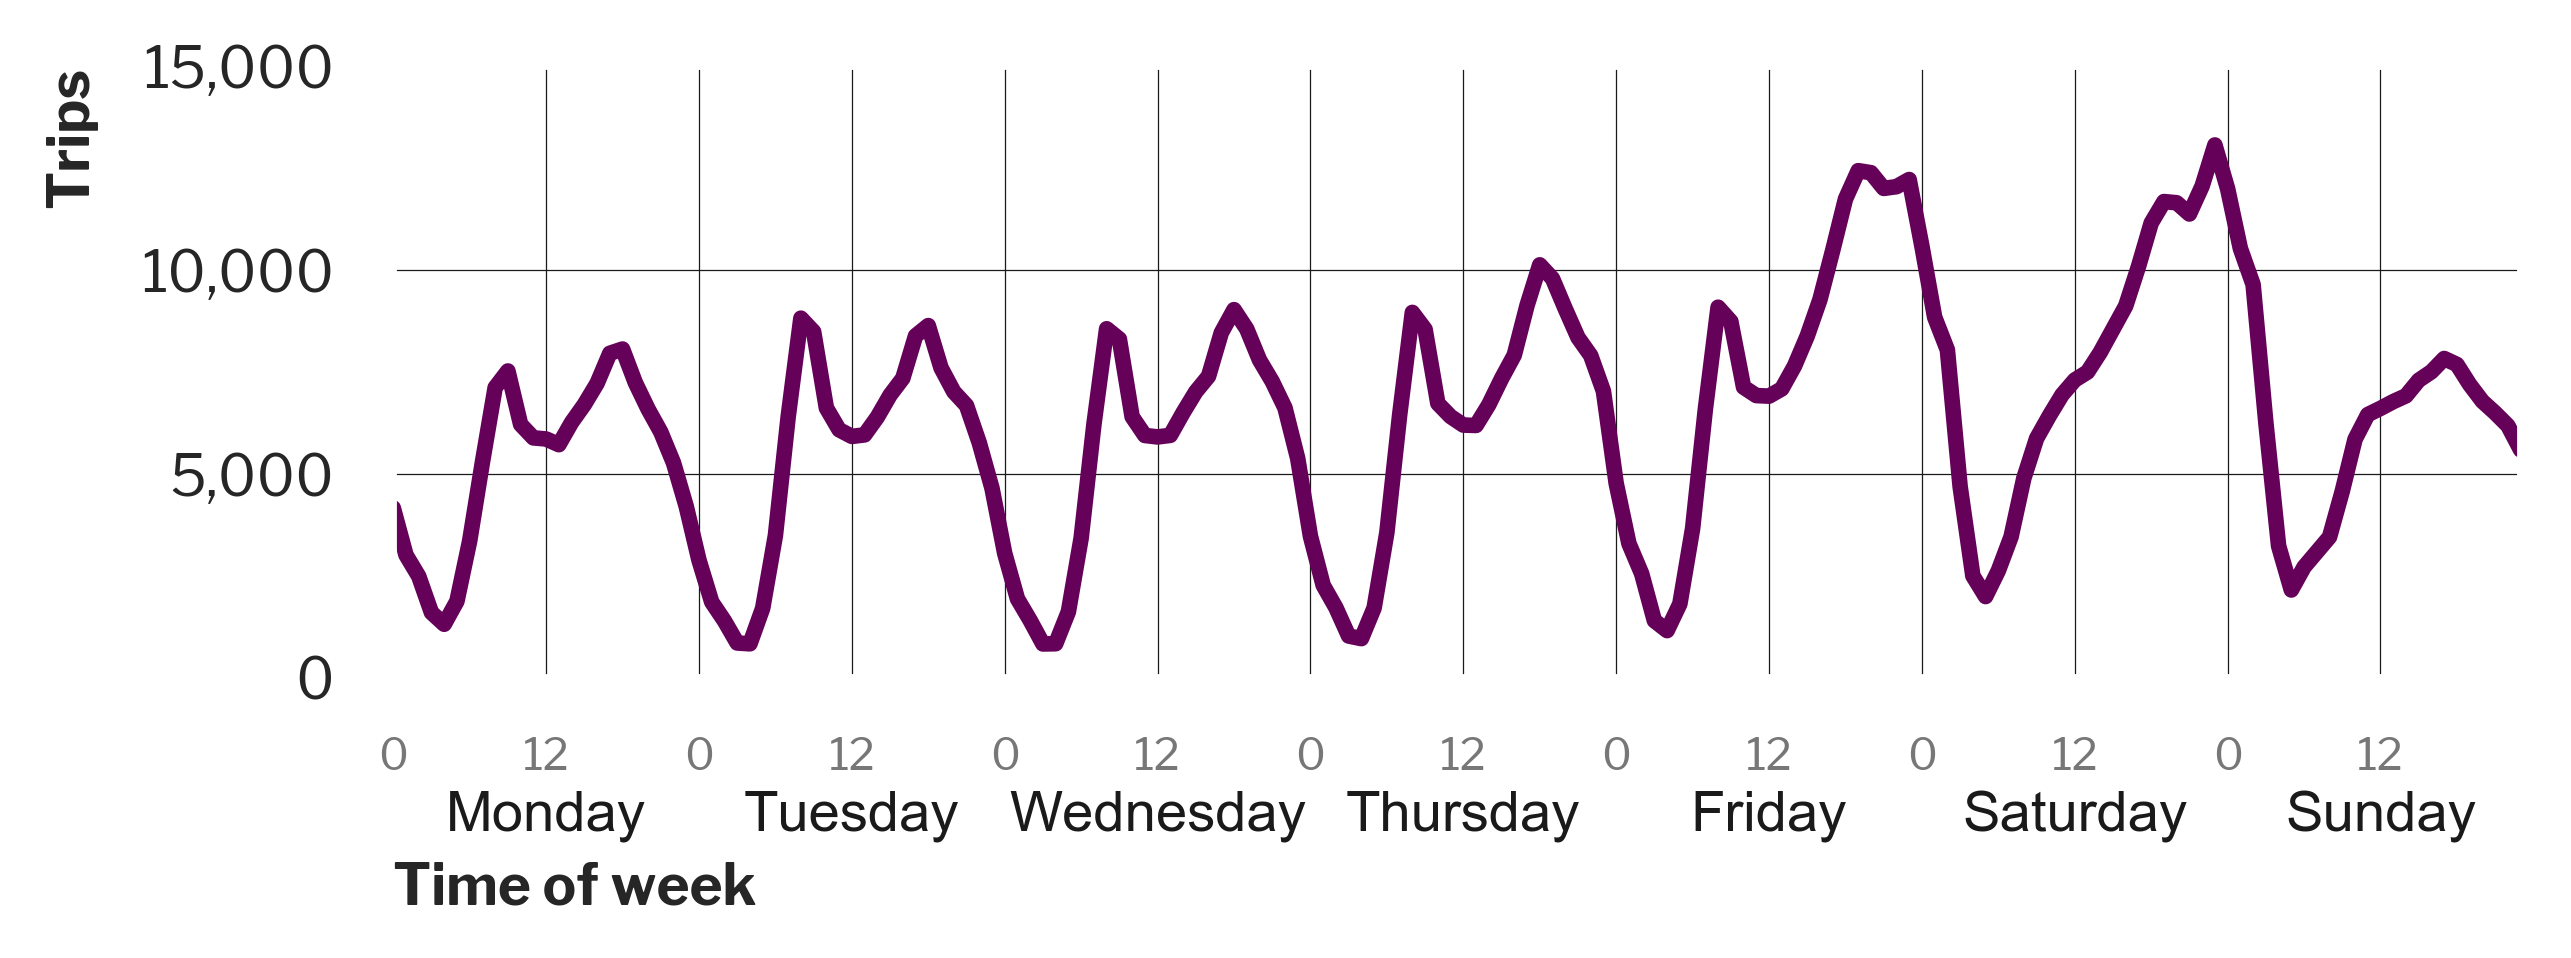

4.356


In [167]:
fig, ax = rick.charts.tow_chart(data = count_18['count'], ylab='Trips')

In [168]:
importlib.reload(rick)

<module 'rick' from '/home/rliu/bdit_python_utilities/charts/rick.py'>

In [154]:
count_18.max()

period_uid       10.0
count         13068.4
hr               23.0
dow               7.0
dtype: float64